<a href="https://colab.research.google.com/github/ajankowi/Praca_inz/blob/master/Siec/Zlaczone_siec_4_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
print(sys.version)

3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]


In [2]:
#from google.colab import drive
#drive.mount("/content/drive", force_remount=True)

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, regularizers
from keras.layers import Flatten, add, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping


print("TensorFlow version:", tf.__version__)
tf.keras.backend.set_floatx('float64')

TensorFlow version: 2.9.2


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import csv
import random

import cv2
import imutils
import glob
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [5]:
#Określenie ścieżek do plików
test_zip = '/content/drive/MyDrive/Sieci/Baza_zdjec_zlaczone_2/Test.zip'
test_csv = 'test.csv'

train_zip = '/content/drive/MyDrive/Sieci/Baza_zdjec_zlaczone_2/Train.zip'
train_csv = 'train.csv'

folder = '/content/drive/MyDrive/Sieci/Baza_zdjec_zlaczone_2/'
slesh = '/'
png = '.png'

In [6]:
#!unzip '/content/drive/MyDrive/Sieci/Baza_zdjec_zlaczone_2/Train.zip' -d '/content/train/'
#!unzip '/content/drive/MyDrive/Sieci/Baza_zdjec_zlaczone_2/Test.zip' -d '/content/test/'

In [7]:
def release_list(a):
    
    del a[:]
    del a

In [8]:
#Wczytanie etykiet do treninegu 

with open(folder+train_csv,"r") as csvfile:
    lines = csvfile.readlines()
csvfile.close()

new = []

for i in lines:
    new.append(i.split(" "))

    
value_train = []
for i in new[0]:
    value_train.append(int(i))    
    
print(len(value_train))

22680


In [9]:
#Wczytanie etykiet do testowania

with open(folder+test_csv,"r") as csvfile:
    lines = csvfile.readlines()
csvfile.close()

new = []

for i in lines:
    new.append(i.split(" "))

    
value_test = []
for i in new[0]:
    value_test.append(int(i))    
    
print(len(value_test))

2520


In [10]:
#Wczytanie zdjęć treningowych 
images_train = []
size = len(value_train)

for i in range(size):
    im = Image.open('/content/train/'+str(i)+'.png')
    arr_im = np.array(im) 
    arr_im = arr_im / 255.0
    images_train.append(arr_im) 
print(len(images_train))

22680


In [11]:
#Wczytanie zdjęć testowych 
images_test = []
size = len(value_test)

for i in range(size):
    im = Image.open('/content/test/'+str(i)+'.png')
    arr_im = np.array(im) 
    arr_im = arr_im / 255.0
    images_test.append(arr_im) 
print(len(images_test))

2520


In [12]:
#Losowanie próbek tablic
rand_list = []
rand_list = np.zeros((len(images_train)), dtype=np.uint8)

x_train = []
y_train = []


#Losowanie zbioru uczącego
for i in range(len(images_train)):
    
    #Pierwsze losowanie wartości
    rand = random.randint(0,len(images_train)-1)
    
    #Sprawdzenie czy wylosowana wartość się powtarza
    while (rand_list[rand] == 1) :
        #Jeżeli tak to ponownie losuje
        rand = random.randint(0,len(images_train)-1)
    
    #Zapisanie zdjecia i wartości do nowej tablicy
    x_train.append(images_train[rand])
    y_train.append(value_train[rand])
    rand_list[rand] = 1


1
[[0.    0.    0.    ... 0.204 0.188 0.   ]
 [0.216 0.227 0.22  ... 0.212 0.196 0.   ]
 [0.227 0.235 0.235 ... 0.216 0.2   0.   ]
 ...
 [0.    0.196 0.173 ... 0.125 0.129 0.125]
 [0.    0.184 0.173 ... 0.129 0.118 0.11 ]
 [0.    0.165 0.18  ... 0.    0.    0.   ]]


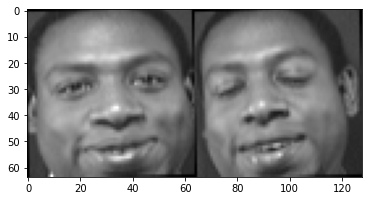

In [13]:
a = 20000

plt.imshow(x_train[a],cmap = 'gray')
print(y_train[a])

print(x_train[a])

In [14]:
x_train = np.array(x_train)
x_test = np.array(images_test)

y_train = np.array(y_train)
y_test = np.array(value_test)

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 128, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.BatchNormalization())


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='relu'))


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 126, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 30, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 14, 30, 32)       128       
 ormalization)                                                   
                                                        

In [17]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy','mse'])

#Funcka umożliwia zatrzymanie się uczenia 
#gdy wartość strat przstanie maleć
EarlyStop = EarlyStopping(monitor='val_loss',  
                          verbose=1, 
                          patience=10)


ModelCheck = ModelCheckpoint(filepath='/content/drive/MyDrive/Sieci/Zlaczone.h5',
                             monitor='val_loss',
                             save_best_only=True)


history = model.fit(x=x_train, 
                    y=y_train, 
                    epochs=100,
                    batch_size=128,
                    validation_split=0.1,
                    #validation_data = (x_test, y_test),
                    callbacks = [EarlyStop, ModelCheck]
                   )

Epoch 1/100
160/160 [==============================] - 28s 142ms/step - loss: 0.1862 - accuracy: 0.8061 - mse: 0.1862 - val_loss: 0.6035 - val_accuracy: 0.5062 - val_mse: 0.6035
Epoch 2/100
160/160 [==============================] - 22s 136ms/step - loss: 0.0212 - accuracy: 0.9879 - mse: 0.0212 - val_loss: 1.1777 - val_accuracy: 0.5071 - val_mse: 1.1777
Epoch 3/100
160/160 [==============================] - 23s 144ms/step - loss: 0.0095 - accuracy: 0.9979 - mse: 0.0095 - val_loss: 0.2134 - val_accuracy: 0.7354 - val_mse: 0.2134
Epoch 4/100
160/160 [==============================] - 23s 145ms/step - loss: 0.0048 - accuracy: 0.9996 - mse: 0.0048 - val_loss: 0.0228 - val_accuracy: 0.9877 - val_mse: 0.0228
Epoch 5/100
160/160 [==============================] - 24s 148ms/step - loss: 0.0034 - accuracy: 0.9999 - mse: 0.0034 - val_loss: 0.0075 - val_accuracy: 0.9978 - val_mse: 0.0075
Epoch 6/100
160/160 [==============================] - 23s 146ms/step - loss: 0.0027 - accuracy: 1.0000 - mse:

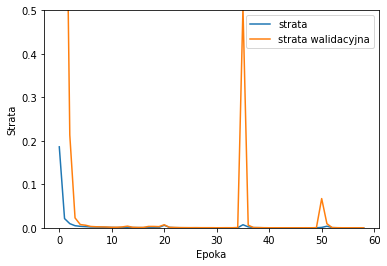

In [18]:
plt.plot(history.history['loss'], label='strata')
plt.plot(history.history['val_loss'], label = 'strata walidacyjna')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.ylim([0.0, 0.5])
plt.legend(loc='upper right')

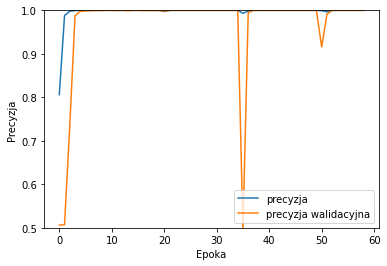

In [19]:
plt.plot(history.history['accuracy'], label='precyzja')
plt.plot(history.history['val_accuracy'], label = 'precyzja walidacyjna')
plt.xlabel('Epoka')
plt.ylabel('Precyzja')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [20]:
best_model = tf.keras.models.load_model('/content/drive/MyDrive/Sieci/Zlaczone.h5')


In [21]:
best_model.evaluate(x_test,  y_test, verbose=2)

79/79 - 1s - loss: 0.1257 - accuracy: 0.8429 - mse: 0.1257 - 1s/epoch - 19ms/step


[0.12567794973433727, 0.8428571428571429, 0.12567794973433727]

In [22]:
predict_x = best_model.predict(x_test) 

predictions = (predict_x > 0.5).astype("int32")

79/79 [==============================] - 1s 11ms/step


In [23]:
names = [['Tn','Nn'],['Np', 'Tp']]
names = np.reshape(names,(2,2))
print(names)

conf = tf.math.confusion_matrix(y_test,predictions)

print(conf)

[['Tn' 'Nn']
 ['Np' 'Tp']]
tf.Tensor(
[[ 880  380]
 [  16 1244]], shape=(2, 2), dtype=int32)
